<a href="https://colab.research.google.com/github/aidot-kr/AISecurity/blob/master/13_BERT_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.9 MB/s eta 0:00:00


In [ ]:
!pip install neattext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 7.8 MB/s eta 0:00:00


In [ ]:
import spacy
import re
import nltk
import string
import sklearn
import neattext as nt
import neattext.functions as nfx
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from collections import Counter
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import AutoTokenizer, TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-large-cased')
bert = TFBertModel.from_pretrained('bert-large-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path1 = '/content/drive/My Drive/bert/new_dataset3_big.csv'
df = pd.read_csv(file_path1)

In [ ]:
df.head()

,Text,oh_label
0,`- This is not ``creative``. Those are the di...,0
1,- Important note for all sysops: There is a ...,0
2,`:If you ever claimed in a Judaic studies prog...,0
3,"`Someone wrote: More recognizable, perhaps, is...",0
4,gets far more tendentious yet.,0


In [ ]:
df['oh_label'].value_counts()

0    72549
1    72482
Name: oh_label, dtype: int64

In [ ]:
# 데이터 1 칼럼 불필요 한거 없애기
df.isnull().sum()

Text        0
oh_label    0
dtype: int64

In [ ]:
print(df.isnull())

         Text  oh_label
0       False     False
1       False     False
2       False     False
3       False     False
4       False     False
...       ...       ...
145026  False     False
145027  False     False
145028  False     False
145029  False     False
145030  False     False

[145031 rows x 2 columns]


In [ ]:

from html import unescape
# Preprocess text function
def preprocess_text(text):
    # 1. Find #[xX]?\w+; and put '&' to the first
    text = re.sub(r'(^|\D)#\w+;', lambda match: f'&{match.group()}' if match.group().startswith('#') else f'{match.group()[0]}&{match.group()[1:]}', text)
    # 2. Convert HTML character to unicode
    text = unescape(text)
    # 3. Remove http, https
    text = re.sub(r'http\S+|https\S+', '', text)
    # 4. Remove email
    text = re.sub(r'\S+@\S+', '', text)
    # 5. Remove twitter id
    text = re.sub(r'@\w+', '', text)
    # 6. Remove "&lt;/b&gt;"
    text = re.sub(r'&lt;/b&gt;', '', text)
    # 7. Remove &quot; and quot;
    text = re.sub(r'&quot;|quot;', '', text)
    # 8. Replace &amp; and amp; with &
    text = re.sub(r'&amp;|amp;', '&', text)
    # 9. Replace &lt; and lt; with <
    text = re.sub(r'&lt;|lt;', '<', text)
    # 10. Replace &gt; and gt; with >
    text = re.sub(r'&gt;|gt;', '>', text)
    # 11. Remove the text inside parentheses
    text = re.sub(r'\(.*?\)', '', text)
    # 12. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # 13. Remove #
    text = re.sub(r'#[\w]*', '', text)
    # Remove user handles
    text = re.sub(r'@\w+', '', text)
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    return text


In [ ]:
df['Text'] = df['Text'].apply(preprocess_text)

In [ ]:
'''df['Text'] = df['Text'].apply(nfx.remove_hashtags)
df.head()'''

,Text,oh_label
0,"""i really don't understand your point.\xa0 It ...",0
1,"""A\\xc2\\xa0majority of Canadians can and has ...",0
2,"""listen if you dont wanna get married to a man...",0
3,"""@SDL OK, but I would hope they'd sign him to ...",0
4,"""Yeah and where are you now?""",0


In [ ]:
'''df['Text'] = df['Text'].apply(nfx.remove_userhandles)
df.head()

,Text,oh_label
0,"""i really don't understand your point.\xa0 It ...",0
1,"""A\\xc2\\xa0majority of Canadians can and has ...",0
2,"""listen if you dont wanna get married to a man...",0
3,""" OK, but I would hope they'd sign him to a o...",0
4,"""Yeah and where are you now?""",0


In [ ]:
'''df['Text'] = df['Text'].apply(nfx.remove_multiple_spaces)
df.head()

,Text,oh_label
0,"""i really don't understand your point.\xa0 It ...",0
1,"""A\\xc2\\xa0majority of Canadians can and has ...",0
2,"""listen if you dont wanna get married to a man...",0
3,""" OK, but I would hope they'd sign him to a on...",0
4,"""Yeah and where are you now?""",0


In [ ]:
df['Text'] = df['Text'].apply(nfx.remove_stopwords)
df.tail()

,Text,oh_label
145026,"` :::::::::::::Again, WP:NOTAFORUM `",0
145027,`The lead lacks proper citation sources. Sayin...,0
145028,"` Yes, word ``Guci`` ``Puci`` meaning ``flash`...",0
145029,:The way trying describe article step sources ...,0
145030,== Warning == clearly protectionist regime goi...,0


In [ ]:
'''df['Text'] = df['Text'].apply(nfx.remove_urls)
df.tail()

,Text,oh_label
46298,true. nice watch racism incident. Ricky pick a...,1
46299,"Black ppl expected anything, depended anything...",1
46300,swear God. dumb nigger bitch. got bleach hair ...,1
46301,"Yea fuck RT YOURE NIGGER FUCKING UNFOLLOW ME, ...",1
46302,Bro. U gotta chill RT Dog FUCK KP dumb nigger ...,1


In [ ]:
'''df['Text'] = df['Text'].str.replace('RT', '', regex=True)
df.tail()

,Text,oh_label
46298,true. nice watch racism incident. Ricky pick a...,1
46299,"Black ppl expected anything, depended anything...",1
46300,swear God. dumb nigger bitch. got bleach hair ...,1
46301,"Yea fuck : YOURE NIGGER FUCKING UNFOLLOW ME, F...",1
46302,Bro. U gotta chill : Dog FUCK KP dumb nigger b...,1


In [ ]:
df1 = df[df['oh_label'] == 1]
df1.head()

,Text,oh_label
5,"""shut fuck up. rest faggot friends burned stake""",1
6,"""Either fake extremely stupid...maybe both...""",1
13,"""your dickhead...""",1
14,"""Your retard post head %&*""",1
27,"""Allinit123, your\xa0hypocrisy\xa0is sickening...",1


## Train, Test set 나누기

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")


Training set size: 101521
Validation set size: 21755
Test set size: 21755


In [ ]:
df_train.tail()

,Text,oh_label
101516,== fuck == fuck misterwiki. fuck misterwiki. f...,1
101517,` ::::those ``abbreviations`` hyperlinks links...,0
101518,vandalize Wikipedia Page mistake....He new pla...,0
101519,"second look-through, prose smidge choppy place...",0
101520,`I'm putting concentrating things. going touch...,0


## 4. 버트 인풋 만들기


In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')


토큰화 확인

In [ ]:
import random
random_index = random.choice(df.index.tolist())
random_row = df.loc[random_index]


text = random_row['Text']
tokens = tokenizer.tokenize(text)

print(f"Original Text: {text}")
print(f"Tokens: {tokens}")

Original Text: Lastly, Islamic scholars agree Muslims Jews Christians worship God Muslims Christians accept birth Jesus. bother saying 'scholars agree me'. Coz . them, idiot knows nothing.
Tokens: ['Last', '##ly', ',', 'Islamic', 'scholars', 'agree', 'Muslims', 'Jews', 'Christians', 'worship', 'God', 'Muslims', 'Christians', 'accept', 'birth', 'Jesus', '.', 'bother', 'saying', "'", 'scholars', 'agree', 'me', "'", '.', 'Co', '##z', '.', 'them', ',', 'idiot', 'knows', 'nothing', '.']


In [ ]:
import numpy as np
from tqdm import tqdm
from transformers import BertTokenizer

SEQ_LEN = 128
BATCH_SIZE = 32
DATA_COLUMN = "Text"
LABEL_COLUMN = "oh_label"

# BERT 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')


def convert_data(data_df):
    tokens, masks, segments, targets = [], [], [], []

    for index, row in tqdm(data_df.iterrows(), total=data_df.shape[0]):
        token = tokenizer.encode(row[DATA_COLUMN], max_length=SEQ_LEN, truncation=True, padding='max_length')
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        segment = [0]*SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        targets.append(row[LABEL_COLUMN])

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets



# df_train 변환
train_x, train_y = convert_data(df_train)


# df_val 변환
val_x, val_y = convert_data(df_val)

# df_test 변환
test_x, test_y = convert_data(df_test)




100%|██████████| 21755/21755 [00:15<00:00, 1407.26it/s]


In [ ]:
train_x

[array([[  101,   134,   134, ...,     0,     0,     0],
        [  101,  8034,  2162, ...,     0,     0,     0],
        [  101, 24819,   119, ...,     0,     0,     0],
        ...,
        [  101,  3498,  6919, ...,     0,     0,     0],
        [  101,  1248,  1440, ...,     0,     0,     0],
        [  101,   169,   146, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [ ]:
import tensorflow as tf


gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"{len(gpus)} GPU(s) are available")
else:
    print("No GPUs are available")


1 GPU(s) are available


In [ ]:
from tensorflow.keras.optimizers import AdamW

opt = AdamW(learning_rate=1.0e-5, weight_decay=0.0025)


In [ ]:
from keras.backend import relu
def create_malicious_comment_bert():
    # 버트 pretrained 모델 로드
    model = TFBertModel.from_pretrained('bert-large-cased')
    # 토큰 인풋, 마스크 인풋, 세그먼트 인풋 정의
    token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
    mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
    segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')
    # 인풋이 [토큰, 마스크, 세그먼트]인 모델 정의
    bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

    bert_outputs = bert_outputs[1]
    dropout = tf.keras.layers.Dropout(0.1)(bert_outputs) #ver 6 드롭아웃 추가
    malicious_comment_first = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(bert_outputs)
    malicious_comment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], malicious_comment_first)

    malicious_comment_model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    return malicious_comment_model


In [ ]:
import os
import tensorflow as tf

# GPU 사용 여부 설정
USE_GPU = True

if USE_GPU:
    # 텐서플로가 첫 번째 GPU만을 사용하도록 제한
    os.environ["CUDA_VISIBLE_DEVICES"]="0"

    # GPU 메모리 성장 허용
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

# 모델 생성
malicious_comment_model = create_malicious_comment_bert()

# 배치 사이즈를 fit() 함수에서 설정
history = malicious_comment_model.fit(train_x, train_y, epochs=5, shuffle=True, batch_size=BATCH_SIZE, validation_data=(val_x, val_y))


Physical devices cannot be modified after being initialized


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/5
3173/3173 [==============================] - 1074s 307ms/step - loss: 0.6959 - accuracy: 0.8411 - val_loss: 0.2747 - val_accuracy: 0.8923
Epoch 2/5
3173/3173 [==============================] - 929s 293ms/step - loss: 0.4258 - accuracy: 0.8483 - val_loss: 0.2989 - val_accuracy: 0.9018
Epoch 3/5
3173/3173 [==============================] - 926s 292ms/step - loss: 0.3113 - accuracy: 0.8775 - val_loss: 0.2789 - val_accuracy: 0.9128
Epoch 4/5
3173/3173 [==============================] - 927s 292ms/step - loss: 0.2358 - accuracy: 0.9215 - val_loss: 0.2474 - val_accuracy: 0.9027
Epoch 5/5
3173/3173 [==============================] - 927s 292ms/step - loss: 0.1741 - accuracy: 0.9465 - val_loss: 0.3355 - val_accuracy: 0.9268


In [ ]:
# 모델 저장
malicious_comment_model.save_weights('/content/drive/My Drive/bert/malicious_comment_model_(large)_new1.h5')

훈련 및 성능 검증

In [ ]:
def predict_convert_data(data_df):
    global tokenizer
    tokens, masks, segments = [], [], []

    for index, row in tqdm(data_df.iterrows(), total=data_df.shape[0]):
        token = tokenizer.encode(row[DATA_COLUMN], max_length=SEQ_LEN, truncation=True, padding='max_length')
        mask = [1 if i != 0 else 0 for i in token]
        segment = [0]*SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]

def predict_load_data(pandas_dataframe):
    df = pandas_dataframe.copy()  # 입력 데이터프레임을 복사하여 원본 데이터를 변경하지 않도록 합니다.
    df[DATA_COLUMN] = df[DATA_COLUMN].astype(str)
    data_x = predict_convert_data(df)
    return data_x

In [ ]:
# 가중치 로드
malicious_comment_model.load_weights('/content/drive/My Drive/bert/malicious_comment_model_(large)_new1.h5')

# 테스트 데이터 변환
test_x = predict_load_data(df_test)

# 예측
predictions = malicious_comment_model.predict(test_x)

# 실제 값
y_true = df_test['oh_label']

# F1 Score 확인
# F1 Score 확인
print(classification_report(y_true, np.round(predictions,0), digits=3))



100%|██████████| 21755/21755 [00:15<00:00, 1398.77it/s]


680/680 [==============================] - 75s 101ms/step
              precision    recall  f1-score   support

           0      0.946     0.908     0.926     10998
           1      0.909     0.947     0.928     10757

    accuracy                          0.927     21755
   macro avg      0.928     0.927     0.927     21755
weighted avg      0.928     0.927     0.927     21755



In [ ]:
def predict_convert_data(data_df):
    global tokenizer
    tokens, masks, segments = [], [], []

    for index, row in tqdm(data_df.iterrows(), total=data_df.shape[0]):
        token = tokenizer.encode(row[DATA_COLUMN], max_length=SEQ_LEN, truncation=True, padding='max_length')
        mask = [1 if i != 0 else 0 for i in token]
        segment = [0]*SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]

def predict_load_data(pandas_dataframe):
    df = pandas_dataframe.copy()  # 입력 데이터프레임을 복사하여 원본 데이터를 변경하지 않도록 합니다.
    df[DATA_COLUMN] = df[DATA_COLUMN].astype(str)
    data_x = predict_convert_data(df)
    return data_x

In [ ]:
'''def predict_convert_data(data_df):
    global tokenizer
    tokens, masks, segments = [], [], []

    for index, row in tqdm(data_df.iterrows(), total=data_df.shape[0]):
        token = tokenizer.encode(row[DATA_COLUMN], max_length=SEQ_LEN, truncation=True, padding='max_length')
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        segment = [0]*SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]

def predict_load_data(pandas_dataframe):
    df = pandas_dataframe.copy()  # 입력 데이터프레임을 복사하여 원본 데이터를 변경하지 않도록 합니다.
    df[DATA_COLUMN] = df[DATA_COLUMN].astype(str)
    data_x = predict_convert_data(df)
    return data_x


In [ ]:
test_x = predict_load_data(df_test)
predictions = malicious_comment_model.predict(test_x)


100%|██████████| 21755/21755 [00:15<00:00, 1395.19it/s]


680/680 [==============================] - 69s 101ms/step


In [ ]:
test_x

[array([[  101,  1107, 13782, ...,     0,     0,     0],
        [  101,   134,   134, ...,     0,     0,     0],
        [  101,  4819,   171, ...,     0,     0,     0],
        ...,
        [  101,   131,   131, ...,     0,     0,     0],
        [  101,   134,   134, ...,     0,     0,     0],
        [  101,  2993,  1681, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [ ]:
y_true = df_test['oh_label']
print(classification_report(y_true, np.round(predictions,0), digits=3))

              precision    recall  f1-score   support

           0      0.946     0.908     0.926     10998
           1      0.909     0.947     0.928     10757

    accuracy                          0.927     21755
   macro avg      0.928     0.927     0.927     21755
weighted avg      0.928     0.927     0.927     21755



In [ ]:
# 스팸이면 1, 정상이면 0 출력
preds

array([[0.9967769 ],
       [0.3419779 ],
       [0.13685921],
       ...,
       [0.9971931 ],
       [0.99488753],
       [0.9970008 ]], dtype=float32)

우리가 훈련한 모델을 F1 SCORE를 바탕으로 성능 측정
F1 SCORE는 precision과 recall을 가중평균하여 계산합니다
recall은 (모델이 TRUE라고 판정한 것의 숫자)/(전체 TRUE의 숫자)
precision은 (진짜 TRUE) / (모델이 TRUE라고 판정한 것의 숫자)

In [ ]:
import logging
tf.get_logger().setLevel(logging.ERROR)

실제 데이터로 실습하기

In [ ]:
def sentence_convert_data(data):
    global tokenizer
    tokens, masks, segments = [], [], []
    token = tokenizer.encode(data, max_length=SEQ_LEN, truncation=True, padding='max_length')

    num_zeros = token.count(0)
    mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
    segment = [0]*SEQ_LEN

    tokens.append(token)
    segments.append(segment)
    masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]

def malicious_comment_evaluation_predict(sentence):
    data_x = sentence_convert_data(sentence)
    predict = malicious_comment_model.predict(data_x)
    predict_value = np.ravel(predict)
    predict_answer = np.round(predict_value).astype(int).item()  # 수정된 부분

    if predict_answer == 1:  # 수정된 부분
        print("(rate : %.2f) Malicious comment." % predict_value)
    elif predict_answer == 0:  # 수정된 부분
        print("(rate : %.2f) Non-malicious comment." % predict_value)




In [ ]:
def predict_random_data(df):
    random_index = random.choice(df.index.tolist())
    random_text = df.loc[random_index, 'Text']
    prediction = malicious_comment_evaluation_predict(random_text)
    return random_text, prediction
random_text, prediction = predict_random_data(df)
print("Text:", random_text)
print("Prediction:", prediction)


1/1 [==============================] - 0s 60ms/step
(rate : 1.07) Malicious comment.
Text: RT : bitch idiot
Prediction: None


In [ ]:
malicious_comment_evaluation_predict("I'm sexist")


1/1 [==============================] - 0s 66ms/step
(rate : 1.09) Malicious comment.


In [ ]:
malicious_comment_evaluation_predict("you fuck you")

1/1 [==============================] - 0s 62ms/step
(rate : 0.90) Malicious comment.


In [ ]:
malicious_comment_evaluation_predict("hi")

1/1 [==============================] - 0s 59ms/step
(rate : 0.33) Non-malicious comment.


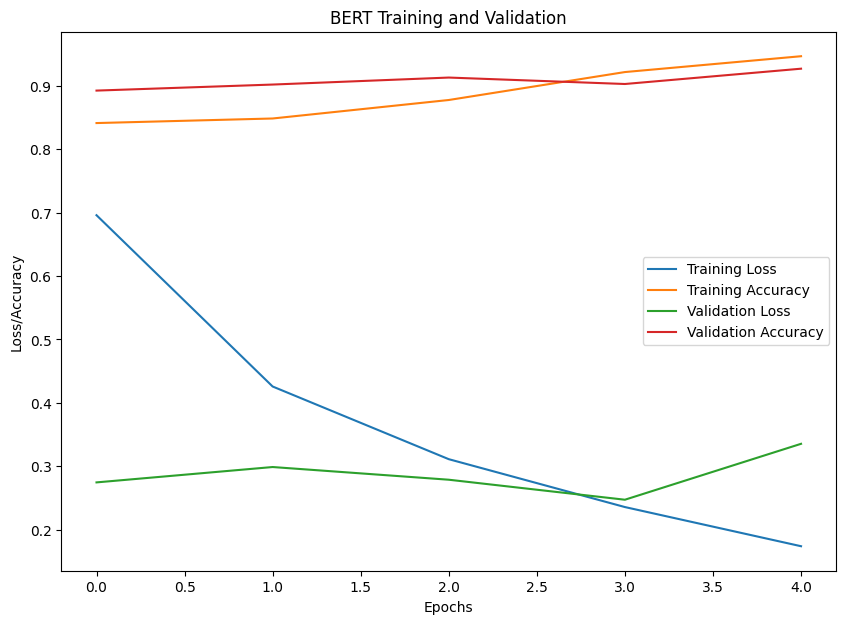

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["accuracy"], label = "Training Accuracy")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")

plt.title('BERT Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

680/680 [==============================] - 69s 101ms/step


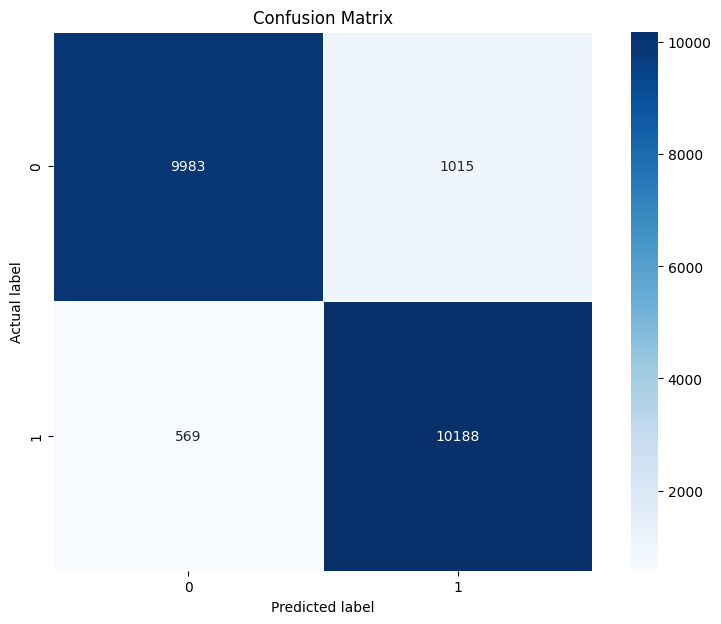

In [ ]:
# 예측
preds = malicious_comment_model.predict(test_x)

# Predicted values
y_pred = np.round(preds, 0)

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
